In [ ]:
import numpy as np
import pandas as pd
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# =============================
# Data loading and preprocessing 
# =============================
A_df = pd.read_csv("ApIcl.csv", index_col=0)

A_df.index = (
    A_df.index.astype(str)
        .str.strip()
        .str.upper()
        .str.replace(r"\.0$", "", regex=True)
)
A_df.columns = A_df.columns.astype(str).str.strip().str.upper()
A_df = A_df.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float32)

# Founders
A_features_founder = {idx: row.values.astype(np.float32) for idx, row in A_df.iterrows()}

def assign_founder_features(df, lookup):
    df = df.copy()
    df["Sire"] = df["Sire"].astype(str)
    df["Dam"]  = df["Dam"].astype(str)
    df["Sire_features"] = df["Sire"].map(lookup)
    df["Dam_features"]  = df["Dam"].map(lookup)
    return df

crosses_df = pd.read_csv("EggsIcl.csv", index_col=0)
crosses_df = assign_founder_features(crosses_df, A_features_founder)

# Feature vector
EXPECTED_DIM = A_df.shape[1]
DEFAULT_VEC = np.zeros(EXPECTED_DIM, dtype=np.float32)

def clean_features(x):
    if isinstance(x, (list, np.ndarray)):
        v = np.asarray(x, dtype=np.float32)
        if v.shape[0] == EXPECTED_DIM:
            return np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
    return DEFAULT_VEC

for col in ["Sire_features", "Dam_features"]:
    crosses_df[col] = crosses_df[col].apply(clean_features)

crosses_df = crosses_df.reset_index(drop=True)

# =========
# Dataloader
# ============
def build_inputs_matrix(df):
    sire = np.stack(df["Sire_features"]).astype(np.float32)
    dam  = np.stack(df["Dam_features"]).astype(np.float32)
    return sire, dam

class FertilityDataset(Dataset):
    def __init__(self, df):
        sire_feats, dam_feats = build_inputs_matrix(df)
        sire_feats = np.nan_to_num(sire_feats, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        dam_feats  = np.nan_to_num(dam_feats,  nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

        self.sire_input = torch.tensor(sire_feats, dtype=torch.float32)
        self.dam_input  = torch.tensor(dam_feats,  dtype=torch.float32)
        self.y          = torch.tensor(df["BinPheno"].values, dtype=torch.float32)

        # IDs
        sire_col, dam_col, cross_col = ["Sire", "Dam", "Cohort.Sib"]
        self.sire_ids  = (df[sire_col].astype(str).tolist() if sire_col  else df.index.astype(str).tolist())
        self.dam_ids   = (df[dam_col].astype(str).tolist()  if dam_col   else df.index.astype(str).tolist())
        self.cross_ids = (df[cross_col].astype(str).tolist() if cross_col else ["" for _ in range(len(df))])

        self._sire_col_name  = sire_col or "SireID_fallback"
        self._dam_col_name   = dam_col or "DamID_fallback"
        self._cross_col_name = cross_col or "CrossID"

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
       
        return (self.sire_input[idx],
                self.dam_input[idx],
                self.y[idx],
                self.sire_ids[idx],
                self.dam_ids[idx],
                self.cross_ids[idx])


# =====
# Model
# ======
class BinaryFertilityModel(nn.Module):
    def __init__(self, input_dim, dropout1=0.2, dropout2=0.2):
        super().__init__()
        self.sire_net = self._make_tower(input_dim, dropout1, dropout2)
        self.dam_net  = self._make_tower(input_dim, dropout1, dropout2)

    @staticmethod
    def _make_tower(input_dim, d1, d2):
        return nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(d1),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(d2),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, sire_input, dam_input):
        a = self.sire_net(sire_input).squeeze(-1)
        b = self.dam_net(dam_input).squeeze(-1)
        return a, b

# =========================
# Helpers: probs, loss, eval
# =========================
def _phi(x: torch.Tensor) -> torch.Tensor:
    # Standard normal CDF
    if hasattr(torch.special, "ndtr"):
        return torch.special.ndtr(x)
    return 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def probs_from_scores(a, b, link="probit", stable=True, eps=1e-7):
    """
    Turn tower outputs a, b into a joint (fused) probability.
    """
    if link == "probit":
        if stable and hasattr(torch.special, "log_ndtr"):
            # log version
            log_p = torch.special.log_ndtr(a) + torch.special.log_ndtr(b)
            p = torch.exp(log_p)
        else:
            p = _phi(a) * _phi(b)
    elif link == "logit":
        if stable:
            # log
            log_p = -F.softplus(-a) + -F.softplus(-b)
            p = torch.exp(log_p)
        else:
            p = torch.sigmoid(a) * torch.sigmoid(b)
    else:
        raise ValueError(f"Unknown link: {link}")

    return torch.clamp(p, min=eps, max=1.0 - eps)


def weighted_bce_on_prob(p, y, pos_weight_value, device):
    per_sample_nll = -(y * torch.log(p) + (1 - y) * torch.log(1 - p))
    pos_w = torch.as_tensor(pos_weight_value, dtype=torch.float32, device=device)
    w = torch.where(y > 0.5, pos_w, torch.tensor(1.0, device=device))
    return (per_sample_nll * w).sum() / w.sum()

@torch.no_grad()
def evaluate_split(model, loader, device="cpu", threshold=0.5,
                   return_ids=False, return_scores=False):
    model.eval()
    all_probs, all_labels = [], []
    all_sire_ids, all_dam_ids, all_cross_ids = [], [], []
    all_a, all_b = [], []

    for batch in loader:

        if len(batch) == 3:
            sire_x, dam_x, y = batch
            sire_ids = dam_ids = cross_ids = None
        else:
            sire_x, dam_x, y, sire_ids, dam_ids, cross_ids = batch

        sire_x, dam_x = sire_x.to(device), dam_x.to(device)
        a, b = model(sire_x, dam_x)

        p_joint = probs_from_scores(a, b, link="probit", stable=True)

        if return_scores:
            all_a.extend(a.detach().cpu().numpy().ravel())
            all_b.extend(b.detach().cpu().numpy().ravel())

        all_probs.extend(p_joint.cpu().numpy().ravel())
        all_labels.extend(y.numpy().ravel())

        if return_ids and sire_ids is not None:
            all_sire_ids.extend(sire_ids)
            all_dam_ids.extend(dam_ids)
            all_cross_ids.extend(cross_ids)

    y_true = np.asarray(all_labels)
    y_prob = np.asarray(all_probs)
    y_pred = (y_prob >= threshold).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    if len(np.unique(y_true)) > 1:
        auc  = roc_auc_score(y_true, y_prob)
        prau = average_precision_score(y_true, y_prob)
    else:
        auc, prau = np.nan, np.nan
    cm = confusion_matrix(y_true, y_pred)

    out = (acc, auc, prau, cm, y_true, y_prob)
    if return_ids and len(all_sire_ids) > 0:
        out += (np.array(all_sire_ids), np.array(all_dam_ids), np.array(all_cross_ids))
    if return_scores:
        out += (np.array(all_a), np.array(all_b))  # latent liabilities
    return out


# =========================
# Training (early stopping)
# =========================
def train_model(model, train_loader, val_loader, pos_weight_value,
                epochs=200, lr=1e-3, weight_decay=1e-4, device="cpu",
                patience=15, max_grad_norm=5.0, return_best_epoch=False):
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_auc = -float("inf")
    best_state = None
    best_epoch = 0
    patience_ctr = 0

    for epoch in range(1, epochs + 1):
        model.train()
        # training loop
        for sire_x, dam_x, y, _sire_ids, _dam_ids, _cross_ids in train_loader:
            sire_x, dam_x, y = sire_x.to(device), dam_x.to(device), y.to(device)
            a, b = model(sire_x, dam_x)
            p = probs_from_scores(a, b, link="probit", stable=False)
            loss = weighted_bce_on_prob(p, y, pos_weight_value, device)
            if not torch.isfinite(loss):
                continue
            optim.zero_grad()
            loss.backward()
            if max_grad_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optim.step()

        acc_v, auc_v, pr_v, _, _, _ = evaluate_split(model, val_loader, device=device, threshold=0.5)
        print(f"Epoch {epoch:03d} | Val Acc {acc_v:.3f} | Val AUC {auc_v:.3f} | Val PR-AUC {pr_v:.3f}")

        if auc_v > best_auc:
            best_auc = auc_v
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"Early stopping at epoch {epoch} — best Val AUC {best_auc:.3f} (epoch {best_epoch})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"Restored best model (Val AUC {best_auc:.3f} at epoch {best_epoch})")
    return (model, best_epoch) if return_best_epoch else model

# ====================================
# 80/20 split + inner 4-fold grid search
# =======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = EXPECTED_DIM

# Grid for first/second layer dropout
dropout1_grid = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
dropout2_grid = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# 80/20 stratified split
groups_all = crosses_df["Cohort"].astype(str).values
y_all      = crosses_df["BinPheno"].values.astype(int)

sgkf_80_20 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
train_idx_all, test_idx = next(sgkf_80_20.split(np.zeros(len(y_all)), y_all, groups_all))

train_df = crosses_df.iloc[train_idx_all].reset_index(drop=True).copy()
test_df  = crosses_df.iloc[test_idx].reset_index(drop=True).copy()
print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")
assert set(train_df["Cohort"]).isdisjoint(set(test_df["Cohort"])), "Group leakage"


# Inner 4-fold CV on 80% for dropout search
inner_groups = train_df["Cohort"].astype(str).values
inner_y      = train_df["BinPheno"].values.astype(int)
inner_cv     = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=SEED)

grid_scores = []  # (d1, d2, mean_auc, mean_prauc)
epoch_book = {}  # key: (d1, d2) -> list of best_epoch

for d1 in dropout1_grid:
    for d2 in dropout2_grid:
        fold_metrics = []
        epoch_book[(d1, d2)] = []
        print(f"\nGrid candidate: dropout1={d1}, dropout2={d2}")

        for tr_idx, val_idx in inner_cv.split(np.zeros(len(inner_y)), inner_y, inner_groups):
            tr_df = train_df.iloc[tr_idx].reset_index(drop=True).copy()
            va_df = train_df.iloc[val_idx].reset_index(drop=True).copy()

            tr_loader = DataLoader(FertilityDataset(tr_df), batch_size=32, shuffle=True)
            va_loader = DataLoader(FertilityDataset(va_df), batch_size=64, shuffle=False)

            n_pos = int((tr_df["BinPheno"] == 1).sum())
            n_neg = int((tr_df["BinPheno"] == 0).sum())
            pos_weight_value = float(n_neg) / max(1.0, float(n_pos))

            model = BinaryFertilityModel(input_dim=input_dim, dropout1=d1, dropout2=d2)
            model, best_ep = train_model(
                model, tr_loader, va_loader, pos_weight_value,
                epochs=200, lr=1e-3, weight_decay=1e-4,
                device=device, patience=15, max_grad_norm=5.0,
                return_best_epoch=True
            )

            acc, auc, prauc, _, _, _ = evaluate_split(model, va_loader, device=device, threshold=0.5)
            fold_metrics.append((acc, auc, prauc))
            epoch_book[(d1, d2)].append(best_ep)

        fm = np.array(fold_metrics, dtype=float)
        mean_auc   = np.nanmean(fm[:, 1])
        mean_prauc = np.nanmean(fm[:, 2])
        grid_scores.append((d1, d2, mean_auc, mean_prauc))
        print(f"  4-fold CV -> Mean AUC={mean_auc:.3f} | Mean PR-AUC={mean_prauc:.3f}")

# Pick best by mean ROC AUC
grid_scores.sort(key=lambda t: (t[2], t[3]), reverse=True)
best_d1, best_d2, best_auc_inner, best_pra_inner = grid_scores[0]

best_epochs = epoch_book[(best_d1, best_d2)]
fixed_epochs = int(np.median(best_epochs)) if len(best_epochs) else 100

print("\n=== GRID SEARCH SUMMARY ===")
print(f"Best (dropout1, dropout2) = ({best_d1}, {best_d2})")
print(f"4-fold mean AUC = {best_auc_inner:.3f} | mean PR-AUC = {best_pra_inner:.3f}")
print("Grid (top 5):")
for row in grid_scores[:5]:
    print(f"  d1={row[0]} d2={row[1]} | mean AUC={row[2]:.3f} | mean PR-AUC={row[3]:.3f}")


In [2]:
# =========================
# Final training on 80% with val, test on 20%
# ============================================
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = EXPECTED_DIM

#best_d1 = 0.0
#best_d2 = 0.5

# Split 80% train_df into train_sub and val_sub
inner_sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
tr_idx, va_idx = next(inner_sgkf.split(
    np.zeros(len(train_df)),
    train_df["BinPheno"].values,
    train_df["Cohort"].astype(str).values
))

tr_df = train_df.iloc[tr_idx].reset_index(drop=True).copy()
va_df = train_df.iloc[va_idx].reset_index(drop=True).copy()

# DataLoaders
tr_loader = DataLoader(FertilityDataset(tr_df), batch_size=32, shuffle=True)
va_loader = DataLoader(FertilityDataset(va_df), batch_size=64, shuffle=False)
te_loader = DataLoader(FertilityDataset(test_df), batch_size=64, shuffle=False)

# Class weight from train_sub
n_pos = int((tr_df["BinPheno"] == 1).sum())
n_neg = int((tr_df["BinPheno"] == 0).sum())
pos_weight_value = float(n_neg) / max(1.0, float(n_pos))

# Train final model with best dropout and early stopping
final_model = BinaryFertilityModel(input_dim=input_dim, dropout1=best_d1, dropout2=best_d2)
final_model = train_model(
    final_model, tr_loader, va_loader, pos_weight_value,
    epochs=300, lr=1e-3, weight_decay=1e-4,
    device=device, patience=15, max_grad_norm=5.0)


acc_t, auc_t, pr_t, cm_t, y_true_t, y_prob_t, sire_ids_t, dam_ids_t, cross_ids_t = evaluate_split(
    final_model, te_loader, device=device, threshold=0.5, return_ids=True)

print("\nFINAL TEST RESULTS")
print(f"Acc={acc_t:.3f} | AUC={auc_t:.3f} | PR-AUC={pr_t:.3f}")
print("Confusion matrix:\n", cm_t)

# IDs + latent scores
res = evaluate_split(
    final_model, tr_loader, device=device, threshold=0.5,
    return_ids=True, return_scores=True
)

# Unpack
(acc_t, auc_t, pr_t, cm_t,
 y_true_t, _y_prob_joint,
 sire_ids_t, dam_ids_t, cross_ids_t,
 a_sire_t, b_dam_t) = res

# Output dataframe: IDs + latent liabilities
out = {
    "SireID": sire_ids_t,
    "DamID":  dam_ids_t,
    "a_sire": a_sire_t,
    "b_dam":  b_dam_t,
}

if any(cross_ids_t):
    out["CrossID"] = cross_ids_t

if isinstance(y_true_t, np.ndarray) and y_true_t.size == a_sire_t.size:
    out["y_true"] = y_true_t

cols = [c for c in ["CrossID","SireID","DamID","y_true","a_sire","b_dam"] if c in out]
latent_df = pd.DataFrame(out, columns=cols)

latent_df.to_csv("final_test_latent_liabilities_with_ids.csv", index=False)
print(latent_df.head())

np.save("latents_sire_a.npy", a_sire_t)
np.save("latents_dam_b.npy",  b_dam_t)



Epoch 001 | Val Acc 0.812 | Val AUC 0.522 | Val PR-AUC 0.816
Epoch 002 | Val Acc 0.815 | Val AUC 0.540 | Val PR-AUC 0.829
Epoch 003 | Val Acc 0.796 | Val AUC 0.548 | Val PR-AUC 0.832
Epoch 004 | Val Acc 0.808 | Val AUC 0.549 | Val PR-AUC 0.833
Epoch 005 | Val Acc 0.547 | Val AUC 0.549 | Val PR-AUC 0.833
Epoch 006 | Val Acc 0.815 | Val AUC 0.549 | Val PR-AUC 0.834
Epoch 007 | Val Acc 0.713 | Val AUC 0.554 | Val PR-AUC 0.835
Epoch 008 | Val Acc 0.803 | Val AUC 0.552 | Val PR-AUC 0.835
Epoch 009 | Val Acc 0.331 | Val AUC 0.560 | Val PR-AUC 0.835
Epoch 010 | Val Acc 0.294 | Val AUC 0.558 | Val PR-AUC 0.834
Epoch 011 | Val Acc 0.324 | Val AUC 0.554 | Val PR-AUC 0.834
Epoch 012 | Val Acc 0.794 | Val AUC 0.566 | Val PR-AUC 0.838
Epoch 013 | Val Acc 0.490 | Val AUC 0.555 | Val PR-AUC 0.835
Epoch 014 | Val Acc 0.315 | Val AUC 0.555 | Val PR-AUC 0.834
Epoch 015 | Val Acc 0.328 | Val AUC 0.555 | Val PR-AUC 0.836
Epoch 016 | Val Acc 0.315 | Val AUC 0.553 | Val PR-AUC 0.834
Epoch 017 | Val Acc 0.38

In [3]:
full_loader = DataLoader(
    FertilityDataset(crosses_df),
    batch_size=64,
    shuffle=False
)

res_full = evaluate_split(
    final_model,
    full_loader,
    device=device,
    threshold=0.5,
    return_ids=True,
    return_scores=True
)

(acc_f, auc_f, pr_f, cm_f,
 y_true_f, _yprob_f,
 sire_ids_f, dam_ids_f, cross_ids_f,
 a_sire_f, b_dam_f) = res_full

np.save("latents_full_sire_a.npy", a_sire_f)
np.save("latents_full_dam_b.npy", b_dam_f)



Confusion Matrix:
 [[ 13  59]
 [ 62 665]]


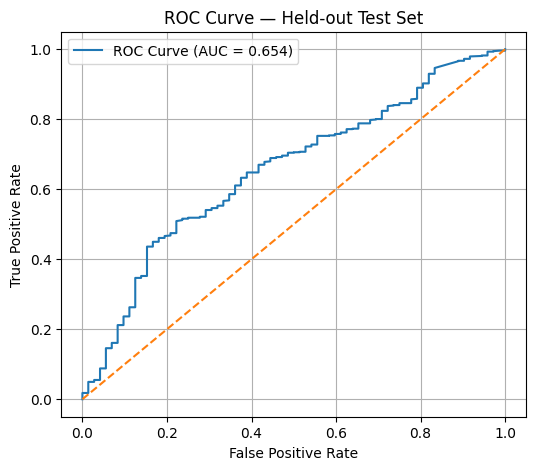

In [ ]:
final_model.eval()
all_labels, all_probs = [], []

with torch.no_grad():
    for sire_x, dam_x, y, _, _, _ in te_loader:
        sire_x, dam_x = sire_x.to(device), dam_x.to(device)
        a, b = final_model(sire_x, dam_x)

        probs = probs_from_scores(a, b, link="probit", stable=True)

        all_probs.extend(probs)
        all_labels.extend(y.numpy())

all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)
pred_labels = (all_probs >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(all_labels, pred_labels)
print("\nConfusion Matrix:\n", cm)

# ROC + AUC
auc_val = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_val:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Final Test")
plt.legend()
plt.grid(True)
plt.show()
